# BIFROST UNION Backend

In [1]:
import mcstasscript as ms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mcstasscript.tools.ncrystal_union import add_ncrystal_union_material

#my_configurator = ms.Configurator()
#my_configurator.set_mcrun_path("/Applications/McStas-3.4.app/Contents/Resources/mcstas/3.4/bin/")
#my_configurator.set_mcstas_path("/Applications/McStas-3.4.app/Contents/Resources/mcstas/3.4/")

""" These line are nessecary in the mcstas test enviroment for the code to compile """

my_configurator = ms.Configurator()
my_configurator.set_mcrun_path("/Users/kristinekrighaar/opt/anaconda3/envs/mcstas_test/bin/")
my_configurator.set_mcstas_path("/Users/kristinekrighaar/opt/anaconda3/envs/mcstas_test/share/mcstas/resources")

### Importing all the detector backend information

In [2]:
ana = pd.read_csv(r'backend_information_Analyzer_information.csv')
ana = ana.replace(',','.', regex=True)
ana = ana.astype(float)

det = pd.read_csv(r'backend_information_Detector_information.csv')
det = det.replace(',','.', regex=True)
det = det.astype(float)


## Making the virtual source

In [3]:
bi_end = ms.McStas_instr("backend_mockup", input_path="run_folder", output_path="data_folder/bifrost")

##### Setting instrument parameters #####
#E0 = bi_end.add_parameter("E0")
#dE = bi_end.add_parameter("dE")

#E0.value = 7.0
#dE.value = 0.5

A4 = bi_end.add_parameter("A4", comment="Scattering angle from sample")
A4.value = 70 # 

A3 = bi_end.add_parameter("A3", comment="Sample rotation angle")
A3.value = 20 # 

std_setting = '"HighFlux_OptimalLamBand.mcpl"' # bi_end.add_parameter("std_setting", comment="Name of .mcpl file for standard setting")


EndOfGuideToSampleLength = 0.58




The following components are found in the work_directory / input_path:
     Union_abs_logger_1D_space_event.comp
     Phonon_simple.comp
These definitions will be used instead of the installed versions.


## Sample Environment

In [4]:

"""
Virtual source for backend, either Source simple or MCPL file (Later to be included)
"""
##### Source simple #####
#source = bi_end.add_component("source", "Source_simple", AT=[0, 0, 0], RELATIVE="ABSOLUTE")
#source.set_parameters(radius = 0.5, yheight=0.01, xwidth=0.01, focus_xw=0.005, focus_yh=0.005, dist = EndOfGuideToSampleLength, E0=E0, dE=dE)

##### Virtual MCPL source #####

virtual_source = bi_end.add_component("Vir_source", "MCPL_input", RELATIVE="ABSOLUTE")
virtual_source.filename = std_setting


sample_pos = bi_end.add_component("sample_pos", "Arm", AT=[0, 0, EndOfGuideToSampleLength], ROTATED=[0, 0, 0], RELATIVE="ABSOLUTE")
A3_rot = bi_end.add_component("A3_rot", "Arm", AT=[0, 0, 0], ROTATED=[0, "A3", 0], RELATIVE="sample_pos") # Sample needs to be relative to this arm
A4_rot = bi_end.add_component("A4_rot", "Arm", AT=[0, 0, 0], ROTATED=[0, "A4", 0], RELATIVE="sample_pos") # Detector tank components needs to be relative to this arm


"""
Sample enviroment
"""
####### Incoherent sample

#incoherent_sample = bi_end.add_component("Incoherent_sample", "Incoherent", AT=[0,0,0], ROTATED=[0, 0, 0], RELATIVE="A3_rot")
#incoherent_sample.radius = 0.0025
#incoherent_sample.yheight = 0.005
#incoherent_sample.order = 1
#incoherent_sample.Etrans = 0.0
#incoherent_sample.target_x = "sin((A4 + 40) * M_PI / 180.0)"
#incoherent_sample.target_z = "0.58+cos((A4 + 40) * M_PI / 180.0)"
#incoherent_sample.focus_ah = 8
#incoherent_sample.focus_aw = 120

#arm_check = bi_end.add_component('arm_check', 'Arm', AT=[incoherent_sample.target_x,0,incoherent_sample.target_z])


####### Phonon simpel

phonon_sample = bi_end.add_component("phonon_sample", "Phonon_simple", AT=[0,0,0], ROTATED=[0, 0, 0], RELATIVE="A3_rot")
phonon_sample.radius = 0.0025
phonon_sample.yheight = 0.005
phonon_sample.sigma_abs = 0.171
phonon_sample.sigma_inc = 0.003
phonon_sample.a = 4.95
phonon_sample.b = 9.4
phonon_sample.M = 207.2
phonon_sample.c = 10.0
phonon_sample.DW = 1.0
phonon_sample.T = 290.0
phonon_sample.target_x = "sin((A4 + 40) * PI / 180.0)"
phonon_sample.target_z = "0.58+cos((A4 + 40) * PI / 180.0)"
phonon_sample.focus_ah = 8
phonon_sample.focus_aw = 120




In [5]:
#bi_end.component_help('Phonon_simple')

#print(A4.value)

## Defining all the scattering processes needed

In [6]:
init = bi_end.add_component("init", "Union_init") # This component has to be called init

################################### Aluminium #############################

Al_inc = bi_end.add_component("Al_inc", "Incoherent_process")
Al_inc.sigma = 4*0.0082 # 4 atoms per unit cell
Al_inc.unit_cell_volume = 66.4

Al_pow = bi_end.add_component("Al_pow", "Powder_process")
Al_pow.reflections = '"Al.laz"'

Al = bi_end.add_component("Al", "Union_make_material")
Al.process_string = '"Al_inc,Al_pow"'
Al.my_absorption = 100*4*0.231/66.4 # barns [m^2 E-28]*Å^3 [m^3 E-30]=[m E-2]

##################################### PG ##################################

#PG_crystal = bi_end.add_component("PG_crystal", "NCrystal_process")
#PG_crystal.cfg = "C_sg194_pyrolytic_graphite.ncmat;mos=20arcmin;dir1=@crys_hkl:0,0,2@lab:1,0,0;dir2=@crys_hkl:9,9,9@lab:9,9,9;dirtol=180deg"

PG_crystal = add_ncrystal_union_material(bi_end, "PG_crystal" ,cfgstr="C_sg194_pyrolytic_graphite.ncmat;mos=50arcmin;dir1=@crys_hkl:0,0,2@lab:0,0,1;dir2=@crys_hkl:9,9,9@lab:9,9,9;dirtol=180deg;temp=25C", split=True)


##################################### HE3 ##################################

"""
All of the He3 calculations in this section is from Mads Bertelsen and the QENS exercise from the DMSC school 2023 wich i attended.
"""

def mu_gas(sigma, bars, temperature_C):
        pressure_Pa = bars * 1e5
        number_density_mol_per_m3 = pressure_Pa / (8.3145 * (temperature_C + 273.15))
        number_density_per_m3 = number_density_mol_per_m3 * 6.022e23
        number_density_per_A3 = number_density_per_m3 / 1e30
        return sigma * number_density_per_A3 * 100

He3_pressure_bars = 3
He3_temperature_C = 25

He3_inc = bi_end.add_component("He3_inc", "Incoherent_process")
He3_inc.sigma = mu_gas(1.6, bars=He3_pressure_bars, temperature_C=He3_temperature_C)
He3_inc.unit_cell_volume = 100

He3 = bi_end.add_component("He3", "Union_make_material")
He3.process_string = '"He3_inc"'
He3.my_absorption = mu_gas(5333, bars=He3_pressure_bars, temperature_C=He3_temperature_C)


In [7]:
#bi_end.show_components()

## Setting up the geometries

### Backend geometry

In [8]:
Detector_names = []


def make_backend_set(wedge_num, energy, energy_string, priority_offset, ang_offset, wedge_name):
    wedge_info = ana[ana["wedge_number"] == wedge_num]
    ana_en_info = wedge_info[wedge_info["Energy"] == energy]
    arm_info = np.squeeze(ana_en_info[ana_en_info["Blade_number"] == 1].to_numpy())

    wedge_info_det = det[det["Wedge number"] == wedge_num]
    det_info = np.squeeze(wedge_info_det[wedge_info_det["Energy"] == energy].to_numpy())
    
    
    ana_arm = bi_end.add_component("ana_arm_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name), "Arm", AT=[0, 0, arm_info[3]], ROTATED=[0, 0, 0], RELATIVE="wedge_arm"+"_"+str(ang_offset))
    
    for i in range(len(ana_en_info)):
        info = np.squeeze(ana_en_info[ana_en_info["Blade_number"] == i+1].to_numpy())
        
        crystal_name = "PG_piece_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(i)+"_"+str(wedge_name)

        PG_piece = bi_end.add_component(crystal_name, "Union_box", AT=[0, info[8]/1000, info[7]/1000], ROTATED=[-(90-info[9]), 0, 0], RELATIVE=ana_arm)
        PG_piece.set_parameters(xwidth=info[5], yheight=info[6], zdepth=0.001, priority=priority_offset+(i+1)/10, material_string='"PG_crystal"')

        
    ########################################### Making the detector section #########################################
    
    det_arm = bi_end.add_component(
        "det_arm_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name), "Arm",
        AT=[0, det_info[3], det_info[2]], ROTATED=[0, 0, 0], RELATIVE="wedge_arm"+"_"+str(ang_offset))
    
    
    det_close_outer = bi_end.add_component("det_close_outer_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name), "Union_cylinder", AT=[0, np.tan(np.radians(2*info[9]-90))*(2*0.0127+0.001), -(2*0.0127+0.001)], ROTATED=[0,0,90], RELATIVE="det_arm_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name))
    det_close_outer.set_parameters(yheight=det_info[4]+0.02, radius=0.0127, priority=priority_offset+0.11, material_string='"Al"')
    
    det_close_He3 = bi_end.add_component("det_close_He3_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name), "Union_cylinder", AT=[0, np.tan(np.radians(2*info[9]-90))*(2*0.0127+0.001), -(2*0.0127+0.001)], ROTATED=[0,0,90], RELATIVE="det_arm_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name))
    det_close_He3.set_parameters(yheight=det_info[4], radius=0.0127-0.001, priority=priority_offset+0.12, material_string='"He3"')

    detector_space_close = bi_end.add_component("signal_tof_1Dspace_close"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name), "Union_abs_logger_1D_space_tof", RELATIVE="det_close_He3_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name))
    
    detector_space_close.target_geometry = '"'+"det_close_He3_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name)+'"'
    detector_space_close.yheight = det_info[4]#(0.0127-0.001)*2
    detector_space_close.n = 100
    detector_space_close.time_min = 0 # REMEMBER TO CHANGE TO CLEAVER VLAUE!!!!
    detector_space_close.time_max = 0.25 # REMEMBER TO CHANGE TO CLEAVER VLAUE!!!!
    detector_space_close.time_bins = 100 # REMEMBER TO CHANGE TO REALISTIC VLAUE!!!!
    detector_space_close.filename = '"'+"detector_signal_1Dspace_close_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name)+".dat"+'"'
    

    
    det_mid_outer = bi_end.add_component("det_mid_outer_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name), "Union_cylinder", AT=[0, 0, 0], ROTATED=[0,0,90], RELATIVE="det_arm_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name))
    det_mid_outer.set_parameters(yheight=det_info[4]+0.02, radius=0.0127, priority=priority_offset+0.14, material_string='"Al"')
    
    det_mid_He3 = bi_end.add_component("det_mid_He3_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name), "Union_cylinder", AT=[0, 0, 0], ROTATED=[0,0,90], RELATIVE="det_arm_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name))
    det_mid_He3.set_parameters(yheight=det_info[4], radius=0.0127-0.001, priority=priority_offset+0.15, material_string='"He3"')
    
    detector_space_mid = bi_end.add_component("signal_tof_1Dspace_mid_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name), "Union_abs_logger_1D_space_tof", RELATIVE="det_mid_He3_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name))
    
    detector_space_mid.target_geometry = '"'+"det_mid_He3_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name)+'"'
    detector_space_mid.yheight = det_info[4]#(0.0127-0.001)*2
    detector_space_mid.n = 100
    detector_space_mid.time_min = 0 # REMEMBER TO CHANGE TO CLEAVER VLAUE!!!!
    detector_space_mid.time_max = 0.25 # REMEMBER TO CHANGE TO CLEAVER VLAUE!!!!
    detector_space_mid.time_bins = 100 # REMEMBER TO CHANGE TO REALISTIC VLAUE!!!!
    detector_space_mid.filename = '"'+"detector_signal_1Dspace_mid_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name)+".dat"+'"'
   
    
    det_far_outer = bi_end.add_component("det_far_outer_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name), "Union_cylinder", AT=[0,-np.tan(np.radians(2*info[9]-90))*(2*0.0127+0.001), (2*0.0127+0.001)], ROTATED=[0,0,90], RELATIVE="det_arm_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name))
    det_far_outer.set_parameters(yheight=det_info[4]+0.02, radius=0.0127, priority=priority_offset+0.17, material_string='"Al"')
    
    det_far_He3 = bi_end.add_component("det_far_He3_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name), "Union_cylinder", AT=[0, -np.tan(np.radians(2*info[9]-90))*(2*0.0127+0.001), (2*0.0127+0.001)], ROTATED=[0,0,90], RELATIVE="det_arm_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name))
    det_far_He3.set_parameters(yheight=det_info[4], radius=0.0127-0.001, priority=priority_offset+0.18, material_string='"He3"')
    
    detector_space_far = bi_end.add_component("signal_tof_1Dspace_far_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name), "Union_abs_logger_1D_space_tof", RELATIVE="det_far_He3_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name))
    
    detector_space_far.target_geometry = '"'+"det_far_He3_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name)+'"'
    detector_space_far.yheight = det_info[4]#(0.0127-0.001)*2
    detector_space_far.n = 100
    detector_space_far.time_min = 0.002 # REMEMBER TO CHANGE TO CLEAVER VLAUE!!!!
    detector_space_far.time_max = 0.25 # REMEMBER TO CHANGE TO CLEAVER VLAUE!!!!
    detector_space_far.time_bins = 9200 # REMEMBER TO CHANGE TO REALISTIC VLAUE!!!!
    detector_space_far.filename = '"'+"detector_signal_1Dspace_far_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name)+".dat"+'"'


    Detector_names.append("det_close_He3_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name))
    Detector_names.append("det_mid_He3_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name))
    Detector_names.append("det_far_He3_"+str(wedge_num)+"_"+str(energy_string)+"_"+str(wedge_name))

    
#print(make_backend_set(1,5.0,"5p0",5,0))

### Making a wedge

In [9]:


def make_a_wedge(wedge_type, priority_offset, ang_offset, wedge_name):
    wedge_arm = bi_end.add_component("wedge_arm"+"_"+str(ang_offset), "Arm", AT=[0, 0, 0], ROTATED=[0, ang_offset, 0], RELATIVE="A4_rot")
    for i in range(len(energy)):
        make_backend_set(wedge_type, energy[i], energy_string[i], priority_offset+i, ang_offset, wedge_name) # wedge_num, energy, energy_string, priority_offset
        
    
#print(make_a_wedge(1,1,20,1))

# Build full BIFROST Backend

In [10]:

energy = np.array([5.0])#, 3.2, 3.8, 4.4, 5.0])
energy_string = np.array(["5p0"])#, "3p2", "3p8", "4p4", "5p0"])

ang_offset = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80]) # which angular offsets should each wedge be at (-40, -30, -20, -10, 0, 10, 20, 30, 40)

wedge_types = np.array([1, 2, 3, 1, 2, 3, 1, 2, 3]) # What type each wegde should be 
wedge_names = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8]) # what should be the name of each wedge


def Build_BIFROST(wedge_types, ang_offset, wedge_names):
    for i in range(len(wedge_types)):
        make_a_wedge(wedge_types[i], ang_offset[i], ang_offset[i], wedge_names[i])

print(Build_BIFROST(wedge_types, ang_offset, wedge_names))


None


## Adding the loggers

In [11]:
# One 1D, ToF, event logger to rule them all

Detector_names = ','.join(Detector_names)

Detector_names ='"'+Detector_names+'"'

#detector_event_far = bi_end.add_component("signal_tof_event_all", "Union_abs_logger_1D_space_event", RELATIVE="det_close_He3_1_2p7_1")
    
#detector_event_far.target_geometry = Detector_names
#detector_event_far.yheight = (0.0127-0.001)*2
#detector_event_far.n = 100
#detector_event_far.filename = '"detector_signal_event_all"'


## Finish off the instrument

In [12]:

master = bi_end.add_component("master", "Union_master")

stop = bi_end.add_component("stop", "Union_stop")



# Running the instrument simuation

In [13]:
bi_end.set_parameters(A3=60, A4=30)
bi_end.settings()  # NeXus=True

data = bi_end.backengine();



INFO: Using directory: "/Users/kristinekrighaar/Documents/BIFROST/McStasScript/data_folder/bifrost_12"
INFO: Regenerating c-file: backend_mockup.c
         Move them into an INITIALIZE section. May fail at compile.
         Move them into an INITIALIZE section. May fail at compile.
CFLAGS= -Wl,-rpath,CMD(mcpl-config --show libdir) -LCMD(mcpl-config --show libdir) -lmcpl -ICMD(mcpl-config --show includedir) -Wl,-rpath,CMD(ncrystal-config --show libdir) CMD(ncrystal-config --show libpath) -ICMD(ncrystal-config --show includedir) -I@MCCODE_LIB@/share/ -DFUNNEL 
    
 The parameter format of Al_pow is initialized 
 using a static {,,,} vector.
  -> Such static vectors support literal numbers ONLY.
  -> Any vector use of variables or defines must happen via a 
     DECLARE/INITIALIZE pointer.


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/

In [17]:

data

[
 McStasData: signal_tof_1Dspace_close1_5p0_1 type: 2D  I:222.221 E:21.0594 N:1132.0,
 
 McStasData: signal_tof_1Dspace_mid_1_5p0_1 type: 2D  I:189.837 E:17.1121 N:1096.0,
 
 McStasData: signal_tof_1Dspace_far_1_5p0_1 type: 2D  I:189.836 E:19.2944 N:961.0,
 
 McStasData: signal_tof_1Dspace_close2_5p0_2 type: 2D  I:330.764 E:33.6371 N:1005.0,
 
 McStasData: signal_tof_1Dspace_mid_2_5p0_2 type: 2D  I:275.556 E:26.2417 N:1011.0,
 
 McStasData: signal_tof_1Dspace_far_2_5p0_2 type: 2D  I:292.643 E:29.8808 N:963.0,
 
 McStasData: signal_tof_1Dspace_close3_5p0_3 type: 2D  I:405.058 E:38.4508 N:1167.0,
 
 McStasData: signal_tof_1Dspace_mid_3_5p0_3 type: 2D  I:453.281 E:42.8334 N:1391.0,
 
 McStasData: signal_tof_1Dspace_far_3_5p0_3 type: 2D  I:333.913 E:36.6968 N:1424.0,
 
 McStasData: signal_tof_1Dspace_close1_5p0_4 type: 2D  I:412.281 E:36.8273 N:1133.0,
 
 McStasData: signal_tof_1Dspace_mid_1_5p0_4 type: 2D  I:382.042 E:36.0604 N:1459.0,
 
 McStasData: signal_tof_1Dspace_far_1_5p0_4 type: 

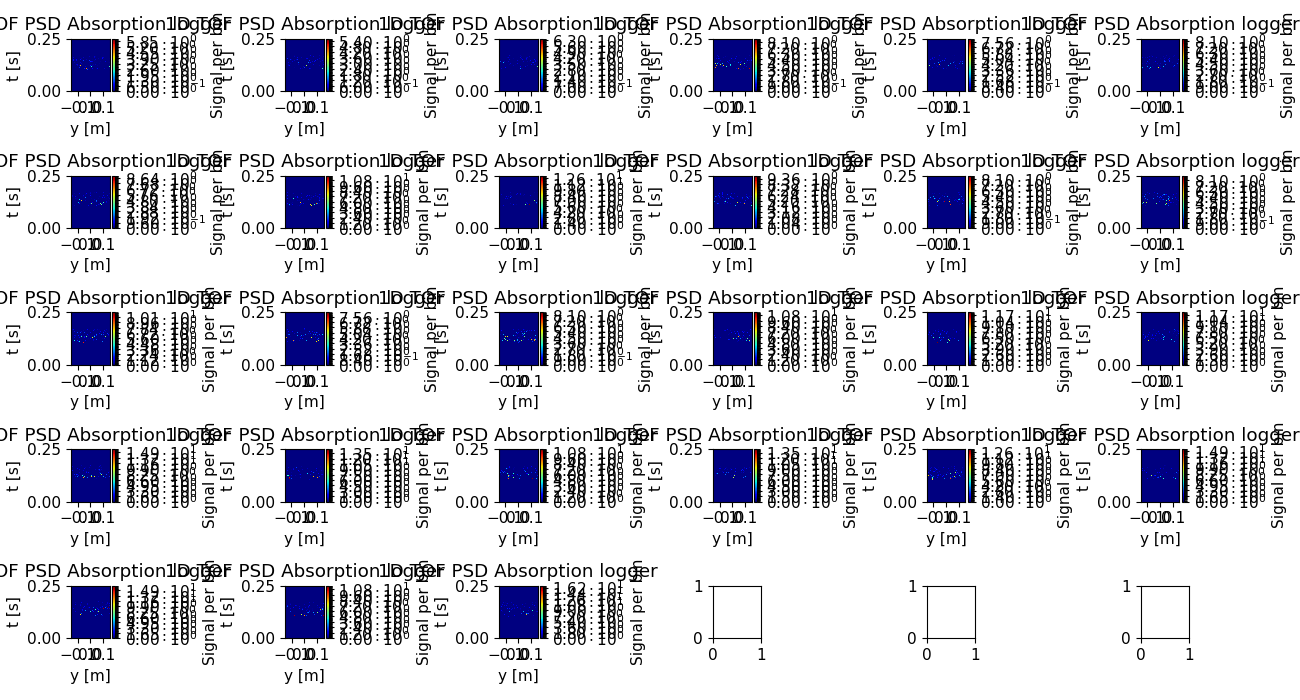

In [19]:

ms.make_sub_plot(data)